In [1]:
!pip install -q "diffusers==0.30.3" "controlnet-aux==0.0.9"

In [2]:
import random

import requests
import torch
from controlnet_aux import ZoeDetector
from PIL import Image, ImageOps

from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    StableDiffusionXLControlNetPipeline,
    StableDiffusionXLInpaintPipeline,
)

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [3]:
def image_scale(original_image):
    aspect_ratio = original_image.width / original_image.height

    if original_image.width > original_image.height:
        new_width = 1024
        new_height = round(new_width / aspect_ratio)
    else:
        new_height = 1024
        new_width = round(new_height * aspect_ratio)

    resized_original = original_image.resize((new_width, new_height), Image.LANCZOS)
    white_background = Image.new("RGBA", (1024, 1024), "white")
    x = (1024 - new_width) // 2
    y = (1024 - new_height) // 2
    white_background.paste(resized_original, (x, y), resized_original)

    return resized_original, white_background


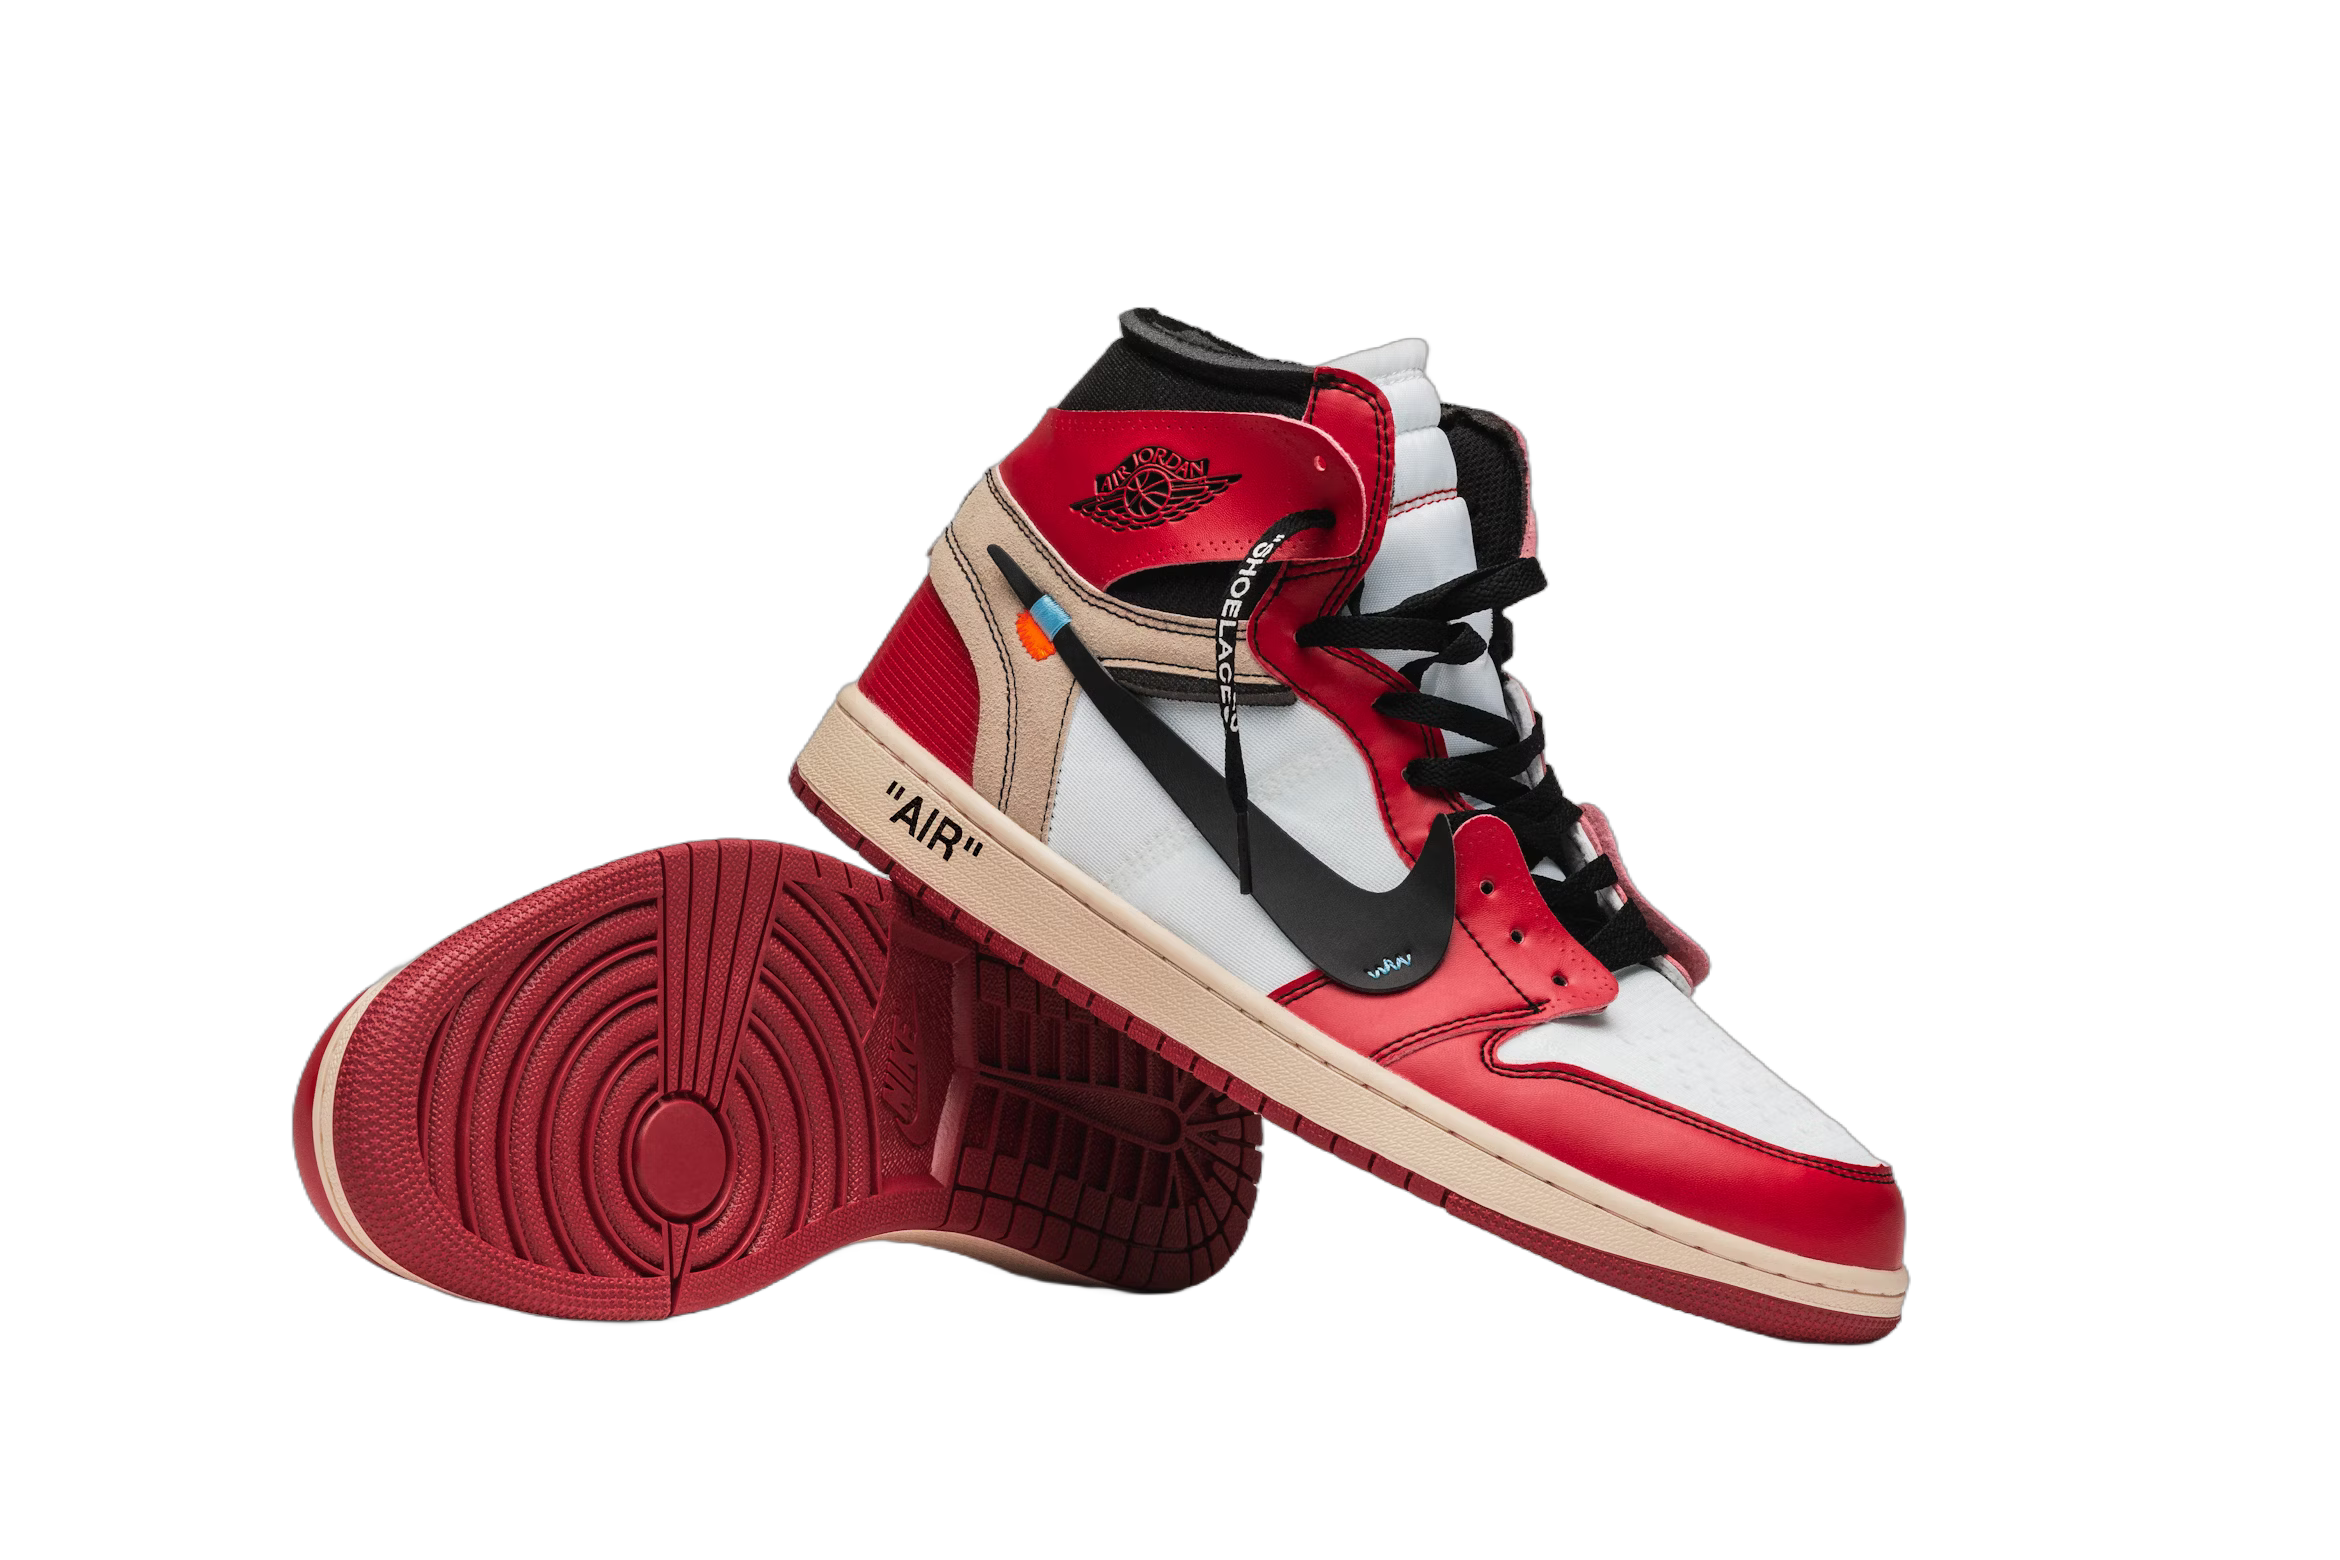

In [4]:
original_image = Image.open(
    requests.get("https://huggingface.co/datasets/stevhliu/testing-images/resolve/main/no-background-jordan.png", stream=True).raw
).convert("RGBA")

original_image

In [5]:
resized_img, white_bg_image = image_scale(original_image)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ZoeD_M12_N.pt:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/controlnet_aux/zoe/__init__.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by t

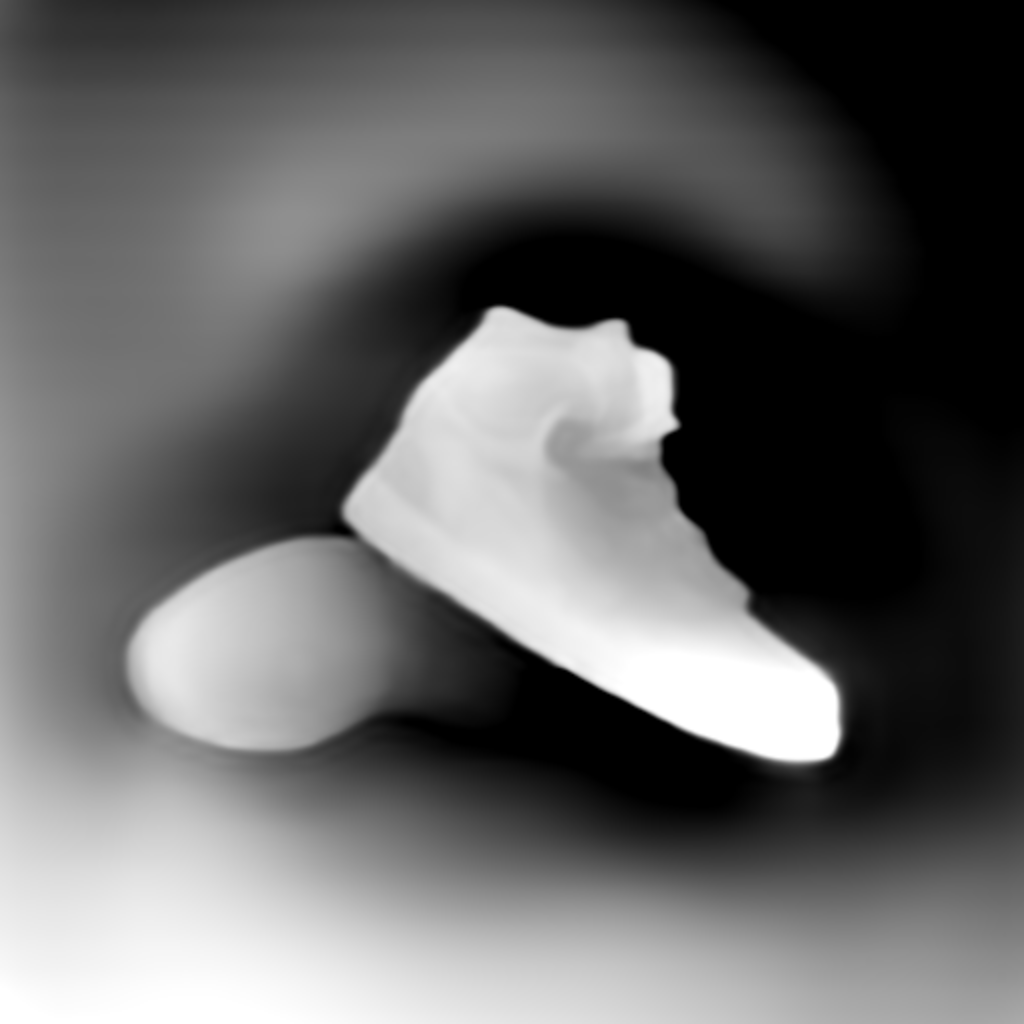

In [8]:
zoe = ZoeDetector.from_pretrained("lllyasviel/Annotators")
image_zoe = zoe(white_bg_image, detect_resolution=512, image_resolution=1024)
image_zoe

### Outpaint

In [9]:
controlnets = [
    ControlNetModel.from_pretrained(
        "destitech/controlnet-inpaint-dreamer-sdxl", torch_dtype=torch.float16, variant="fp16"
    ),
    ControlNetModel.from_pretrained(
        "diffusers/controlnet-zoe-depth-sdxl-1.0", torch_dtype=torch.float16
    ),
]
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(
    "SG161222/RealVisXL_V4.0", torch_dtype=torch.float16, variant="fp16", controlnet=controlnets, vae=vae
).to("cuda")

def generate_image(prompt, negative_prompt, inpaint_image, zoe_image, seed: int = None):
    if seed is None:
        seed = random.randint(0, 2**32 - 1)

    generator = torch.Generator(device="cpu").manual_seed(seed)

    image = pipeline(
        prompt,
        negative_prompt=negative_prompt,
        image=[inpaint_image, zoe_image],
        guidance_scale=6.5,
        num_inference_steps=25,
        generator=generator,
        controlnet_conditioning_scale=[0.5, 0.8],
        control_guidance_end=[0.9, 0.6],
    ).images[0]

    return image

prompt = "nike air jordans on a basketball court"
negative_prompt = ""

temp_image = generate_image(prompt, negative_prompt, white_bg_image, image_zoe, 908097)

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/2.50G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/2.50G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

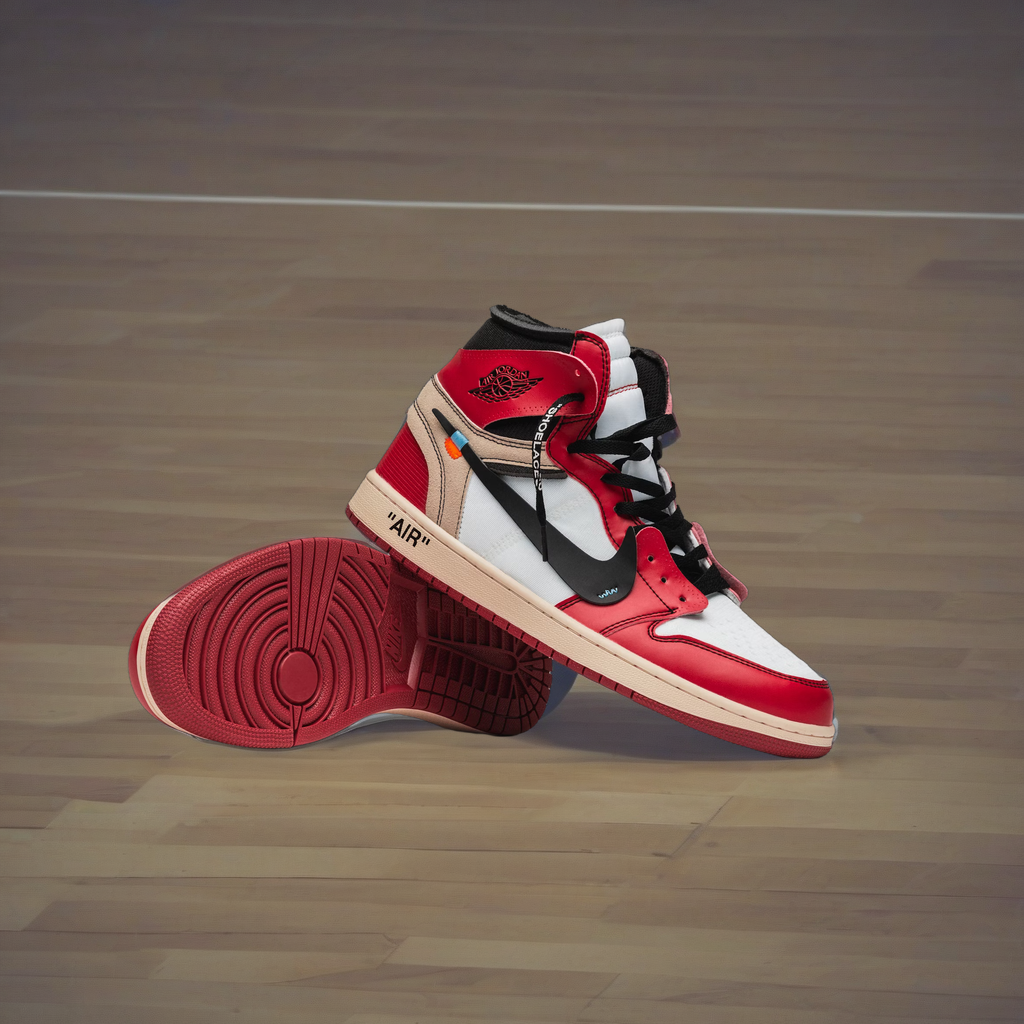

In [10]:
x = (1024 - resized_img.width) // 2
y = (1024 - resized_img.height) // 2
temp_image.paste(resized_img, (x, y), resized_img)
temp_image